<a href="https://colab.research.google.com/github/RenatoCosta10031979/AnaliseExploratoriaAreaDeLogisticaEmpresaXPTO/blob/main/exploracao_logistica_xpto_df.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1\.**Análise e Exploração de Dados: Eficiência e Reestruturação Logística no Distrito Federal**


*Nota: A empresa XPTO mencionada neste projeto é fictícia e utilizada apenas para fins educacionais.*


##2\. **Dicionário**

 - **empresa XPTO**: uma empresa `fíctia` que atua na área de logística no Destrito Federal (Brasília);
 - **name**: uma `string` com o nome único da instância;
 - **region**: uma `string` com o nome único da região do **hub**;
 - **origin**: um `dict` com a latitude e longitude da região do **hub**;
 - **vehicle_capacity**: um `int` com a soma da capacidade de carga dos **veículos** do **hub**;
 - **deliveries**: uma `list` de `dict` com as **entregas** que devem ser realizadas;
 - **id**: uma `string` com o id único da **entrega**;
 - **point**: um `dict` com a latitude e longitude da **entrega**;
 - **size**: um `int` com o tamanho ou a carga que a **entrega** ocupa no **veículo**.

##3\. **Objetivos**
- Otimizar as operações logísticas da empresa XPTO no Distrito Federal, através da distribuição eficiente de veículos, análise do impacto geográfico nas entregas, possível reestruturação dos hubs e ajuste da capacidade da frota à variabilidade das entregas, visando melhorar a eficiência operacional, reduzir tempos de entrega e aumentar a satisfação do cliente.


##4\. **Perguntas de Negócio**
-Como podemos otimizar a distribuição dos veículos entre as três regiões (df-0, df-1, df-2) para melhorar a eficiência das entregas?
Qual é o impacto da dispersão geográfica das entregas, especialmente na região df-0 (vermelha), na eficiência operacional e no tempo de entrega?
Como podemos ajustar a capacidade e quantidade de veículos, considerando a variação no tamanho das entregas e a densidade de entregas em cada região, para melhorar a eficiência e satisfação do cliente?



##5\.**Instalação de Pacotes**

In [13]:
!pip install --upgrade pandera
!pip install --upgrade typeguard
!pip3 install geopandas;

##6\.**Instalação de Bibliotecas**

In [ ]:
#localização geográfica
import geopy
from geopy.geocoders import Nominatim
#Manipulação de dados no formato JSON
import json
#Manipulação e análise de dados
import pandas as pd
#Montar o Google Drive no ambiente Colab
from google.colab import drive
#Baixar arquivos do Google Drive
import gdown
#importando a biblioteca Numpy
import numpy as np
#importando a pandera
#interagir com o sistema oepracional
import os
import pandera as pa
#manipulação de avisos
import warnings
#ignorar avisos durante a excução do código
warnings.filterwarnings("ignore")
#importar a classe RateLimiter do módulo geopy.extra.rate_limiter
#para contrlar a taxa de geocodificação
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import nominatim
#importar o geopadas para visualizar as coordenadas dos hubs e das entregas do Distrito Federal
import geopandas
# importar a biblioteca de plotagem
import matplotlib as plt

##7\.**Exploração De Dados**

###7.1\.**Coleta de Dados**

O dado bruto é um arquivo do tipo JSON com uma lista de instâncias de entregas. Cada instância representa um conjunto de entregas que devem ser realizadas pelos veículos do hub regional. Exemplo:
```json
[
  {
    "name": "cvrp-0-df-0",
    "region": "df-0",
    "origin": {"lng": -47.802664728268745, "lat": -15.657013854445248},
    "vehicle_capacity": 180,
    "deliveries": [
      {
        "id": "ed0993f8cc70d998342f38ee827176dc",
        "point": {"lng": -47.7496622016347, "lat": -15.65879313293694},
        "size": 10
      },
      {
        "id": "c7220154adc7a3def8f0b2b8a42677a9",
        "point": {"lng": -47.75887552060412, "lat": -15.651440380492554},
        "size": 10
      },
      ...
    ]
  }
]
...


####7.1.1\.**Conectar Google Colab ao Google Drive**

In [ ]:
#conectar colab ao google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####7.1.2\.**Download Arquivos Google Drive**

In [14]:
file_id = "1Rt5e8qaGKHawCiqF9wff2dSaAxil8C_l"
output = "deliveries.json"  # Nome do arquivo de saída

gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Rt5e8qaGKHawCiqF9wff2dSaAxil8C_l
To: /content/deliveries.json
100%|██████████| 77.0M/77.0M [00:02<00:00, 34.3MB/s]


'deliveries.json'

####7.1.3\.**Carregar os dados do arquivo 'deliveries.json', em um dicionário Pythton chamado data**

In [15]:
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

```json
[
  {
    "name": "cvrp-0-df-0",
    "region": "df-0",
    "origin": {
      "lng": -47.802664728268745,
      "lat": -15.657013854445248
    },
    "vehicle_capacity": 180,
    "deliveries": [
      {
        "id": "ed0993f8cc70d998342f38ee827176dc",
        "point": {
          "lng": -47.7496622016347,
          "lat": -15.65879313293694
        },
        "size": 10
      },
      {
        "id": "c7220154adc7a3def8f0b2b8a42677a9",
        "point": {
          "lng": -47.75887552060412,
          "lat": -15.651440380492554
        },
        "size": 10
      }
      // ... outros itens
    ]
  }
  // ... outros objetos
]


##8\.**Wrangling**

###8.1\.**Conversão do JSON para DataFrame**

In [16]:
deliveries_df=pd.DataFrame(data)

In [ ]:
#Amostra do dataframe deliveries_df
deliveries_df.head()

Repare que a coluna **origin** contem dados `nested` ou aninhados na estrutura do JSON. Vamos normalizar a coluna com uma operação conhecida como `flatten` ou achatamento que transforma cada chave do JSON em uma nova coluna.



In [18]:
#normalizar a coluna origin
hub_origin_df = pd.json_normalize(deliveries_df["origin"])
hub_origin_df.head()

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145


Com os dados normalizados, o próximo passo é juntar o dataframe hub_origin_df ao dataframe original ( deliveries_df)

In [19]:
#usando merge para juntar os dataframes
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries,lng,lat
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p...",-48.054989,-15.838145
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po...",-48.054989,-15.838145
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p...",-48.054989,-15.838145
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p...",-47.893662,-15.805118
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p...",-48.054989,-15.838145


In [20]:
## Remove a coluna 'origin' e reordena as colunas do DataFrame
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.head()

,name,region,lng,lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


In [21]:
#renomear nomes de algumas colunas
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Repare que a coluna **deliveries** contem dados uma lista de dados `nested` ou aninhados na estrutura do JSON. Vamos normalizar a coluna com uma operação conhecida como `explode` ou explosão que transforma cada elemento da lista em uma linha. Por fim, faremos os `flatten` ou achatamento do resultado coluna.

In [22]:
#aplicando o explode
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")
deliveries_exploded_df.head()

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."


In [23]:
# Cria e combina colunas para 'size', 'lng', e 'lat' a partir da coluna 'deliveries' do DataFrame
deliveries_normalized_df = pd.concat([
    pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
    pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
    pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis=1)
deliveries_normalized_df.head()

,delivery_size,delivery_lng,delivery_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871
0,2,-48.118023,-15.846471
0,7,-48.114898,-15.858055


In [24]:
#Ao excutar o len verificamos a quantidade de linhas que o dataframe original possuí.
len(deliveries_df)

199

In [25]:
#  Nota-se que, ao excutar o código len a quantidade do número de linhas,
#aumentaram significativamente em relação ao dataframe original,
# isso ocorre devido à transformação das listas aninhadas em linhas separadas.
#Embora a quantidade de linhas tenha aumentado no dataframe deliveries_exploded_df as informações são as mesmas em ambos
len(deliveries_exploded_df)


636149

In [26]:
# Remove a coluna 'deliveries' do DataFrame original, pois ela já foi normalizada
#deliveries_df = deliveries_df.drop("deliveries", axis=1)

# Faz a junção mantendo todas as linhas do DataFrame normalizado e adicionando colunas do DataFrame original
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)

# Reseta o índice do DataFrame resultante e remove a coluna de índice antiga
deliveries_df.reset_index(inplace=True, drop=True)

# Exibe as primeiras linhas do DataFrame resultante
deliveries_df.head()


,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p...",9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p...",2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p...",1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p...",2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p...",7,-48.114898,-15.858055


In [27]:
#iremos remover a coluna deliveries do dataframe deliveries_df, porque a coluna deliveries foi normalizada para delivery_ln e delivery_lat
#portanto para manter o dataframe sem redundância iremos remover a coluna deliveries.
deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


###8.2.\.**Estrutura dos Dados**

Conhecendo um pouco melhor a estrutura do nosso


In [28]:
#verificar a quantidade de linhas e colunas que o dataframe tem
deliveries_df.shape

(636149, 8)

In [29]:
# visualizar as colunas do dataframe
deliveries_df.columns

Index(['name', 'region', 'hub_lng', 'hub_lat', 'vehicle_capacity',
       'delivery_size', 'delivery_lng', 'delivery_lat'],
      dtype='object')

In [30]:
#verificar o index
deliveries_df.index

RangeIndex(start=0, stop=636149, step=1)

In [31]:
#verificar as informações gerais da esturtura ( schema) do dataframe
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


##9\.**Schema**

In [32]:
deliveries_df.head(1)

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929


In [33]:
#validação dos tipos de dados e a estrutura do DataFrame para garantir que os dados estejam no formato esperado.
deliveries_df_schema = pa.DataFrameSchema ({
                                'name': pa.Column(pa.Object),
                                'region': pa.Column(pa.Object),
                                'hub_lng': pa.Column(pa.Float64),
                                'hub_lat': pa.Column(pa.Float64),
                                'vehicle_capacity': pa.Column(pa.Int64),
                                'delivery_size': pa.Column(pa.Int64),
                                'delivery_lng': pa.Column(pa.Float64),
                                'delivery_lat': pa.Column(pa.Float64),
})

In [34]:
#confirmação da Validação do Dataframe em relação a schema pré-definido anteriormente.
deliveries_df_schema.validate(deliveries_df)

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055
...,...,...,...,...,...,...,...,...
636144,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,8,-48.064269,-15.997694
636145,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,4,-48.065176,-16.003597
636146,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,9,-48.065841,-16.003808
636147,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,1,-48.062327,-16.001568


### Métricas associadas à contagem e à frequência dos dados. Aqui está uma descrição mais aprimorada:

* count: Indica a quantidade total de linhas no DataFrame, ou seja, o número de observações ou registros presentes.

* unique: Representa a quantidade de valores únicos presentes em uma determinada coluna do DataFrame. Essa métrica é útil para entender a diversidade de valores em uma variável.

* top: Refere-se ao valor mais frequente (mais comum) em uma coluna. Para esse projeto o top representa a instância de entrega que mais se repete em todo o dataframe É o elemento que ocorre com maior frequência.

* freq: Indica a frequência do valor que está no topo (top). Essa métrica representa o número de vezes que o valor mais frequente (top) ocorre na coluna. Em outras palavras, é a contagem do valor mais comum.

In [35]:
# Seleciona todas as colunas do tipo "object" (geralmente strings) do DataFrame deliveries_df
# e gera um resumo estatístico dessas colunas, transpondo o resultado para facilitar a leitura.
deliveries_df.select_dtypes("object").describe()


,name,region
count,636149,636149
unique,199,3
top,cvrp-1-df-87,df-1
freq,5636,304708


In [36]:
# Remove as colunas "name" e "region" do DataFrame deliveries_df
# Isso é feito porque queremos focar apenas nas outras colunas para análise
deliveries_df.drop(["name", "region"], axis=1).select_dtypes('int64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


##10\.**Valores Faltantes**

In [37]:
#identificar quais colunas do dataframe têm possíveis valores ausentes
deliveries_df.isna().any()

,0
name,False
region,False
hub_lng,False
hub_lat,False
vehicle_capacity,False
delivery_size,False
delivery_lng,False
delivery_lat,False


##11\.**Geocodificação**

###11.1\.**Geocodificação reversa dos Hubs**

A **geocodificação** é o processo que transforma uma localização descrita por um texto (endereço, nome do local, etc.) em sua respectiva coodernada geográfica (latitude e longitude). A **geocodificação reversa** faz o oposto, transforma uma coordenada geográfica de um local em suas respectivas descrições textuais.

In [38]:
#criar um dataframe somente com informaçoes dos hubs
hub_df = deliveries_df[["region","hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


###11.2\.**Geocodificação Nominatim**

 Existe uma projeto open source chamado de OpenStreetMap que mantem um serviço gratuito de geocodificação chamado Nominatim. Vamos utilizá-lo através do pacote Python geopy para fazer a operação reversa e enriquecer o nosso DataFrame principal. Abaixo temos um exemplo de gepcodificação reversa usando latitude e longitude de um hub.

In [39]:
# Inicializa o geocodificador Nominatim com um nome de usuário para identificação
geolocator = Nominatim(user_agent= "eda_logistica")
# Obtém a descrição textual da localização para as coordenadas do hub
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")
# Converte o resultado para um formato JSON e imprime de forma legível
print(json.dumps(location.raw, indent=2 ,ensure_ascii=False))

{
  "place_id": 46410411,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright",
  "osm_type": "way",
  "osm_id": 240210480,
  "lat": "-15.656916027876347",
  "lon": "-47.80264463632131",
  "class": "highway",
  "type": "secondary",
  "place_rank": 26,
  "importance": 0.0533433333333333,
  "addresstype": "road",
  "name": "Rua 7",
  "display_name": "Rua 7, Quadra 2, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-127, Brasil",
  "address": {
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Sobradinho",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federal",
    "state

Aplicando  a geocodificação nas coordenadas das três regiões e extrair informações de **cidade** e **bairro**.

In [40]:
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [41]:
# criando uma nova coluna coordinates e transformando os valores das colunas hub_lat e hub_lng em str,
#e posteriormente concatena essas strings que serão armazenadas dentro da nova coluna coordinates do dataframe hub_df
hub_df["coordinates"] = hub_df["hub_lat"].astype(str) + ", " + hub_df["hub_lng"].astype(str)
#faz a geodificação reversa a apartir das coordenadas dos hubs
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
#Visualização do dataframe hub_df
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [42]:
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,46410411,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.053343,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-127,Brasil,br,NaN,NaN,NaN,NaN
1,46401425,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172753950067,-47.89372354453109,highway,residential,26,0.053411,...,Distrito Federal,BR-DF,Região Centro-Oeste,70336-000,Brasil,br,SQS 303,Brasília,NaN,NaN
2,43777060,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.000010,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [43]:
# Seleciona apenas as colunas "address.town", "address.suburb" e "address.city" do DataFrame
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]

# Renomeia as colunas para nomes mais claros: "address.town" para "hub_town", "address.suburb" para "hub_suburb" e "address.city" para "hub_city"
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)

# Substitui valores nulos na coluna "hub_city" pelos valores da coluna "hub_town" se "hub_city" estiver vazio
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])

# Substitui valores nulos na coluna "hub_suburb" pelos valores da coluna "hub_city" se "hub_suburb" estiver vazio
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])

# Remove a coluna "hub_town" do DataFrame, pois já foi integrada na coluna "hub_city"
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)

# Mostra as primeiras linhas do DataFrame resultante
hub_geodata_df.head()


,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


O DataFrame `hub_geodata_df` com as informações de **cidade** e **bairro** é então combinado ao DataFrame `hub_df`, enriquecendo assim o dado.

In [44]:
#junção entre os dataframes hub_df e hub_geodata_df
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
#selecionando colunas no dataframe hub_df
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [45]:
# O DataFrame `hub_df`  é  combinado ao DataFrame principal `deliveries_df`, enriquecendo assim o dado.
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()


,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


###11.3\.**Geocodificação reversa da entrega**

Enquanto o **hub** contem apenas **3** geolocalizações distintas, as **entregas** somam o total de **636.149**, o que levaria em torno de 7 dias para serem consultadas no servidor do Nominatim, dada a restrição de uma consulta por segundo. Contudo, para cargas pesadas como esta, o software oferece uma instalação [local](https://nominatim.org/release-docs/latest/admin/Installation/) (na sua própria máquina) que pode ser utilizada sem restrição.

In [46]:
# URL do Google Sheets
file_url = 'https://docs.google.com/spreadsheets/d/15CshiDB7sMmvplHRbgNJNQfyIVvB6pZnlNjeKtuphKw/edit?usp=drive_link'

# ID do arquivo
file_id = "15CshiDB7sMmvplHRbgNJNQfyIVvB6pZnlNjeKtuphKw"

# URL de download com conversão para CSV
download_url = f"https://docs.google.com/spreadsheets/d/{file_id}/export?format=csv"

# Nome do arquivo de saída
output = "deliveries-geodata.csv"

# Baixando o arquivo
gdown.download(download_url, output, quiet=False)


Downloading...
From: https://docs.google.com/spreadsheets/d/15CshiDB7sMmvplHRbgNJNQfyIVvB6pZnlNjeKtuphKw/export?format=csv
To: /content/deliveries-geodata.csv
44.3MB [00:04, 11.0MB/s]


'deliveries-geodata.csv'

In [47]:
# Lê o arquivo CSV "deliveries-geodata.csv" e armazena os dados em um DataFrame
deliveries_geodata_df = pd.read_csv("/content/deliveries-geodata.csv")

# Exibe as primeiras linhas do DataFrame para verificar o conteúdo
deliveries_geodata_df.head()




,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-4.811.618.888.384.230,-15.848.929.154.862.200,Ceilândia,P Sul
1,-4.811.819.489.551,-15.850.772.371.049.600,Ceilândia,P Sul
2,-4.811.248.339.849.670,-1.584.787.055.941.760,Ceilândia,P Sul
3,-4.811.802.268.617.860,-15.846.471.025.281.400,Ceilândia,P Sul
4,-4.811.489.817.459.100,-1.585.805.462.185.700,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [48]:
 #Realiza o merge (junção) do DataFrame deliveries_df com as colunas "delivery_city" e "delivery_suburb" de deliveries_geodata_df,
# utilizando os índices como chave de junção e mantendo apenas as linhas que aparecem em ambos os DataFrames (inner join)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
# Exibe as primeiras linhas do DataFrame resultante para verificar o conteúdo
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


###11.4\.**Qualidade dos Dados**

In [49]:
#verificar a estrutura do dataframe
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 58.2+ MB


In [50]:
#verificar se há valores faltantes ( ausentes)
deliveries_df.isna().any()

,0
name,False
region,False
hub_lng,False
hub_lat,False
hub_city,False
hub_suburb,False
vehicle_capacity,False
delivery_size,False
delivery_lng,False
delivery_lat,False


In [51]:
# verificar a porcentagem (%) de valores faltantes na coluna delivery_city
(deliveries_df["delivery_city"].isna().sum()/len(deliveries_df)) * 100

0.26754738276724477

In [52]:
# verificar a porcentagem (%) de valores faltantes nas coluna delivery_suburb
deliveries_df["delivery_suburb"].isna().sum()/len(deliveries_df) * 100

25.133262804783158

In [53]:
#Esse código calcula o percentual de entregas em cada cidade e exibe as 10 cidades com os maiores percentuais.
percentual_df_city = deliveries_df[["delivery_city"]].value_counts() /len(deliveries_df) *100
percentual_df_city.sort_values(ascending=False).head(10)

,count
delivery_city,
Brasília,23.419513
Taguatinga,7.162473
Sudoeste / Octogonal,6.950416
Ceilândia,5.966055
Águas Claras,5.829295
Guará,5.561905
Lago Sul,4.561982
Sobradinho,4.541232
Lago Norte,4.083163


In [54]:
#Esse código calcula o percentual de entregas em cada suburbio e exibe as 10 cidades com os maiores percentuais.
percentual_df_subburbio =deliveries_df[["delivery_suburb"]].value_counts()/len(deliveries_df) * 100
percentual_df_subburbio.head(10)

,count
delivery_suburb,
Brasília,8.456352
Asa Norte,7.663928
Taguatinga,6.336251
Asa Sul,5.926285
Águas Claras,5.659838
Guará,5.561905
Samambaia,2.651423
Sobradinho,1.814826
Recanto das Emas,1.502950


##12\.**Visualização**

###12.1\.**Mapa de entregas por região**

Vamos utilizar o pacote Python GeopPandas ([link](https://geopandas.org/) da documentação) para visualizar as coordenadas dos **hubs** e das **entregas** no mapa do Distrito Federal, segmentados pela região dos **hubs**. O pacote adiciona funcionalidades geoespaciais ao pacote Python Pandas.

- **Mapa do Distrito Federal**

Vamos fazer o download dos dados do mapa do Distrito Federal do site oficial do IBGE através do seguinte [link](https://www.ibge.gov.br/geociencias/cartas-e-mapas/bases-cartograficas-continuas) para criar o DataFrame `mapa`. Note a coluna `geometry`.

In [55]:
# Baixa um arquivo ZIP contendo os mapas cartográficos do Distrito Federal a partir do site do IBGE
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip

# Descompacta o arquivo ZIP baixado na pasta "maps"
!unzip -q distrito-federal.zip -d ./maps

# Copia o arquivo shapefile necessário (.shp e .shx) para o diretório de trabalho
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx


In [56]:
# Lê o arquivo shapefile do Distrito Federal usando geopandas e cria um DataFrame geoespacial
mapa_df = geopandas.read_file("distrito-federal.shp")

# Seleciona a primeira linha do DataFrame, que corresponde ao mapa do Distrito Federal
mapa_df = mapa_df.loc[[0]]

# Exibe as primeiras linhas do DataFrame geoespacial para ver as informações carregadas
mapa_df.head()


,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


-**Mapa dos Hubs**

In [57]:
#Criar um dataframe chamado geo_hub_df através do dataframe deliveries_df,
# iremos fazer a junção da coluna geometry do dataframe mapa_df
hub_df = deliveries_df[["region", "hub_lng","hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


-**Mapa das Entregas**

In [58]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


-**Visualização dos Mapas**

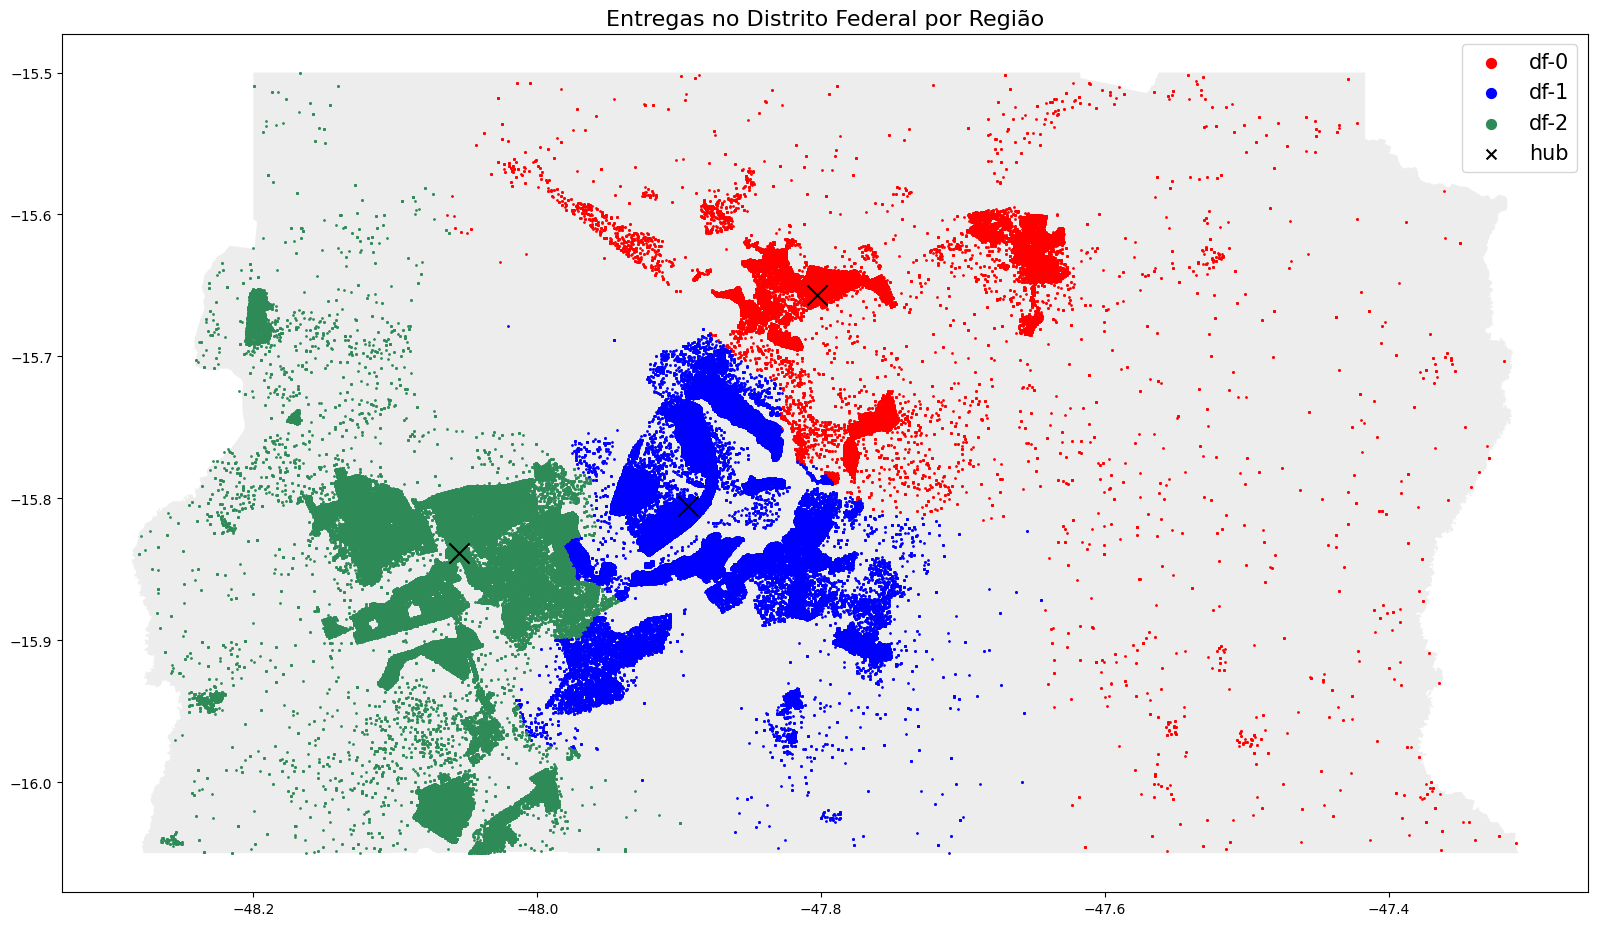

In [59]:
import matplotlib.pyplot as plt

# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa_df.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=210, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])


###13\.**Relatório de Otimização Logística - Empresa XPTO**

### 13.1\. **Introdução**
Este relatório apresenta uma análise abrangente das operações logísticas da empresa XPTO no Distrito Federal, com foco na otimização da distribuição de entregas, eficiência operacional e satisfação do cliente.

#### 13.2\. **Distribuição Geográfica das Entregas**

- **Região df-1 (Azul):**
  - Maior concentração de entregas (304.708 frequência)
  - Área central de Brasília (Asa Sul, Asa Norte, Sudoeste)
  - Alta densidade de entregas sugere eficiência atual dos hubs

- **Região df-0 (Vermelha):**
  - Região norte (Sobradinho, Planaltina)
  - Entregas mais dispersas, cobrindo área mais ampla
  - Potencial sobrecarga do hub ou ineficiência nas rotas

- **Região df-2 (Verde):**
  - Região oeste (Taguatinga, Ceilândia, Samambaia)
  - Mistura de entregas concentradas e dispersas
  - Necessidade de logística flexível

#### 13.3\. **Capacidade e Eficiência dos Veículos**

- **Capacidade padrão:** 180 unidades
- Tamanho médio das entregas: 5,51 unidades (desvio padrão: 2,87)
- Oportunidade para diversificar tamanhos de veículos

#### 13.4\. **Impacto da Dispersão Geográfica**

- **Região df-0:** Maior impacto negativo na eficiência devido à dispersão
  - Potencial aumento no tempo de entrega e custos operacionais
  - Necessidade de estratégias específicas para áreas dispersas

#### 13.5\. **Storytelling: A Jornada de Otimização da XPTO**
A XPTO enfrenta um desafio logístico complexo no Distrito Federal. No centro da operação, na região df-1, a dinâmica das entregas é relativamente eficiente, refletindo uma operação bem ajustada em uma área com alta densidade de demanda.

À medida que nos afastamos dessa região central, encontramos a região df-0, onde as entregas se tornam mais dispersas e a cobertura é mais ampla. Isso resulta em jornadas mais longas e potencialmente maiores custos operacionais.

Na região df-2, a situação é um misto de eficiência e desafios. Algumas áreas apresentam padrões semelhantes ao centro, enquanto outras enfrentam dificuldades típicas de regiões mais distantes.

A XPTO deve focar em adaptar suas operações para atender a essas variações regionais. É necessário ajustar as estratégias de distribuição e alocação de veículos para enfrentar as especificidades de cada área. O objetivo é melhorar a eficiência das entregas e atender melhor às expectativas dos clientes, independentemente da localização.

#### 13.6\. **Recomendações**

##### 13.6.1\. **Otimização da Distribuição de Veículos**
- Implementar um sistema dinâmico de alocação de veículos baseado na demanda diária de cada região
- Considerar a redistribuição de veículos da região df-1 para df-0 em horários de pico

##### 13.6.2\. **Reestruturação de Hubs**
- Avaliar a criação de mini-hubs na região df-0 para reduzir distâncias de entrega
- Otimizar a localização do hub na região df-2 para melhor atender áreas dispersas

##### 13.6.3\. **Ajuste da Capacidade da Frota**
- Introduzir veículos de menor capacidade para atender áreas com entregas menores e mais frequentes
- Manter veículos de grande capacidade para rotas com alta densidade de entregas

##### 13.6.4\. **Otimização de Rotas**
- Implementar um sistema avançado de roteirização para minimizar distâncias percorridas, especialmente na região df-0
- Agrupar entregas próximas para aumentar a eficiência

##### 13.6.5\. **Monitoramento de Desempenho**
- Estabelecer KPIs específicos para cada região, considerando suas características únicas
- Implementar um sistema de feedback em tempo real dos clientes para medir satisfação

### 14\. **Conclusão**
A análise das operações logísticas da XPTO no Distrito Federal revelou oportunidades significativas para otimização. A distribuição geográfica desigual das entregas, especialmente na região df-0, apresenta desafios que podem ser superados através de uma abordagem mais flexível e adaptativa.

Ao adotar uma estratégia que combina a reestruturação de hubs, otimização da frota e implementação de tecnologia avançada de roteirização, a XPTO pode não apenas superar seus desafios atuais, mas também se posicionar como líder em eficiência logística no Distrito Federal. O próximo passo crucial é a implementação faseada destas recomendações, começando com um projeto piloto na região df-0, seguido de uma avaliação cuidadosa dos resultados antes da expansão para outras regiões.
